In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


C:\Users\18gia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open('names.txt', 'r') as f:
    words = f.read().split('\n')
#characters mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} 
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(chars)+1
print(vocab_size)


27


In [4]:
block_size = 3
def build_dataset(words):
    global block_size
    X , Y = [],[]

    for word in words:

        context = [0] * block_size
        #print(word)
        for ch in word + '.':
            X.append(context)
            ix = stoi[ch]
            Y.append(ix)
            # print(''.join(itos[i] for i in context),'--->',itos[ix])
            #update context
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [8]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3453, grad_fn=<NegBackward0>)

In [9]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n
dprobs = (1/probs) * dlogprobs 
dcounts_sum_inv = (counts * dprobs).sum(dim = 1,keepdim = True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = - counts_sum ** -2 * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = norm_logits.exp() * dcounts
dlogits = torch.ones_like(logits) *  dnorm_logits
dlogit_maxes = - (torch.ones_like(logits)* dnorm_logits).sum(dim = 1,keepdim= True) 
max_col_idxs = logits.argmax(dim = 1)
b = torch.zeros_like(logits)
b[range(n),max_col_idxs] = 1.0
dlogits += b * dlogit_maxes
dh = dlogits @ torch.t(W2)
dW2 = torch.t(h) @ dlogits
db2 = (torch.ones_like(h @ W2) *dlogits).sum(dim=0)
dhpreact = (1 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(dim = 0, keepdim = True)
dbnraw = torch.concat([bngain for _ in range(bnraw.shape[0])],0) * dhpreact
dbnbias = (torch.ones_like(hpreact) * dhpreact).sum(dim = 0, keepdim = True)
dbnvar_inv = (bndiff * dbnraw).sum(dim = 0, keepdim = True)
dbndiff = bnvar_inv * dbnraw
dbnvar = -0.5 * (bnvar + 1e-5)**-1.5  * dbnvar_inv
dbndiff2 = 1/(n-1)*(torch.ones_like(bndiff2)) * dbnvar 
dbndiff += 2 * bndiff * dbndiff2
dbnmeani = - (torch.ones_like(bndiff) * dbndiff).sum(dim= 0, keepdim = True) 
dhprebn = torch.ones_like(hprebn) * dbndiff
dhprebn += (1/n)*torch.ones_like(hprebn)*dbnmeani
dembcat = dhprebn @ torch.t(W1)
dW1 = torch.t(embcat) @ dhprebn
db1 = (torch.ones_like(hprebn) * dhprebn).sum(dim = 0)
demb = (torch.ones_like(embcat) * dembcat).view(emb.shape[0],emb.shape[1],emb.shape[2])
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        idx = Xb[i,j]
        dC[idx] += demb[i,j]

C.shape, Xb.shape, emb.shape
#emb = C[Xb] # embed the characters into vectors

(torch.Size([27, 10]), torch.Size([32, 3]), torch.Size([32, 3, 10]))

In [10]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [12]:
#softmax derivation
dlogits = F.softmax(logits,1)
dlogits[range(n),Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 4.423782229423523e-09


In [13]:
F.softmax(logits,1)[0]

tensor([0.0698, 0.0937, 0.0179, 0.0552, 0.0190, 0.0830, 0.0249, 0.0319, 0.0161,
        0.0310, 0.0411, 0.0329, 0.0359, 0.0311, 0.0337, 0.0128, 0.0079, 0.0201,
        0.0162, 0.0527, 0.0470, 0.0194, 0.0244, 0.0743, 0.0583, 0.0283, 0.0213],
       grad_fn=<SelectBackward0>)

In [14]:
dlogits[0] * n

tensor([ 0.0698,  0.0937,  0.0179,  0.0552,  0.0190,  0.0830,  0.0249,  0.0319,
        -0.9839,  0.0310,  0.0411,  0.0329,  0.0359,  0.0311,  0.0337,  0.0128,
         0.0079,  0.0201,  0.0162,  0.0527,  0.0470,  0.0194,  0.0244,  0.0743,
         0.0583,  0.0283,  0.0213], grad_fn=<MulBackward0>)

In [17]:
dlogits[0].sum()
#close to zero

tensor(3.2596e-09, grad_fn=<SumBackward0>)

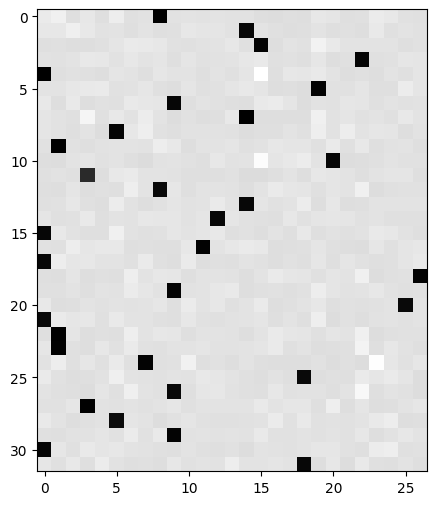

In [16]:
plt.figure(figsize = (6,6))
plt.imshow(dlogits.detach(), cmap = 'gray')


The dlogits are basically Pi for wrong characters and Pi-1 for correct characters.
We have no to imagine the neural network as a system of pulls. If the corect character has Pi = 1 and the other charcater have Pi = 0, then all the derivative are 0 and nothing get pulled. This is what we want since the prediction is correct.
Meanwhile if all the characters have probability 0 and one character which is wrong has Pi = 1. Then the right characther has dlogits = -1 and the wrong character has dlogits = 1. This means that the probability of the right character will be strongly pulled up while the wrong character will be strongly pulled down. This is what we want since the prediction is wrong. The other wrong characters will have dlogits = 0 and will not be pulled.

In [18]:
dhpreabn = bngain * bnvar_inv/n * (n*dhpreact -dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn',dhprebn,hprebn)

hprebn          | exact: True  | approximate: True  | maxdiff: 0.0
